In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import scipy
%matplotlib inline
plt.style.use('seaborn')

In [2]:
import numpy as np
import sklearn
import matplotlib
import pandas as pd
import sys
libraries = (('Matplotlib', matplotlib), ('Numpy', np), ('Pandas', pd))

print("Python Version:", sys.version, '\n')
for lib in libraries:
    print('{0} Version: {1}'.format(lib[0], lib[1].__version__))

Python Version: 3.6.2 |Anaconda custom (64-bit)| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)] 

Matplotlib Version: 2.0.2
Numpy Version: 1.12.1
Pandas Version: 0.20.3


In [4]:
import numpy as np

class make_regression:
    
    def __init__(self):
        """
        Generates a dataset from scratch using random numbers and
        maintaing correlations. To use, instantiate model and call
        "build_dataset" with the requested features. Can add 
        "dirt" to the data my messing up features.
        """
        self.model_params = None
        self.num_feats = None
        self.random_state = None
        self.is_clean = None
        self.noise = None
        self.bias = None
        
    def build_dataset(self, num_feat=10, num_rows=100, random_state = None, num_important=10, 
                      noise=0.1, bias=None, dirty_data=False):
        """
        Actually generates X, y for a dataset. 
        ---
        KWargs:
        num_feat: how many columns in X
        num_rows: how many datapoints
        random_state: sets seed for reproducibility
        num_important: how many of the features actually correlate
                       to the target
        noise: How much jitter to add to the total correlation
        bias: Flag to determine if there is an offset from 0.
        dirty_data: flag to decide if data should have NaNs and duplicate
                    columns (can add manually with "muck_up_data" method later)
        """
        assert num_feat > 0 and num_rows > 0, "Must have rows and features > 0."
        if random_state:
            np.random.seed(random_state)
            self.random_state = random_state

        means = np.random.uniform(-1,1, size=num_feat)
        sigmas = np.random.uniform(1e-6,1, size=num_feat)
        X = np.zeros((num_rows, num_feat))
        for i, mu in enumerate(means):
            X.T[i] = np.random.normal(mu, sigmas[i], num_rows)

        if bias == True:
            bias = np.random.uniform(-1,1)
        elif isinstance(bias, float):
            pass
        else:
            bias = 0.
        
        self.bias = bias

        if num_important > num_feat:
            num_important = num_feat
            
        self.num_important = num_important
        self.num_feats = num_feat

        target_builder = np.random.choice(np.arange(num_feat),num_important, replace=False)
        X_target = X.T[target_builder].T
        betas = np.random.uniform(-1,1,num_important)
        params = []
        for i,j in zip(betas, target_builder):
            params.append((j,i))
        self.model_params = params
        
        y = np.sum(X_target*betas, axis=1) + bias + np.random.normal(0, noise, num_rows)
        
        if dirty_data:
            X = self.muck_up_data(X)
            
        return X, y
    
    def muck_up_data(self, X, dup_cols=True, add_nan=True, combine_feats=True):
        """
        Controller method for how to mess up the data.
        """
        if dup_cols:
            X = self._add_duplicate_columns(X, dup_cols)
        if combine_feats:
            X = self._combine_features(X, combine_feats)
        if add_nan:
            X = self._add_nans(X, add_nan)
        return X
    
    def _add_duplicate_columns(self,X, dup_cols):
        """
        Add duplicate columns to the data. 
        
        If dup_cols is bool, add 10% of the 
        number of columns, min 1.
        If dup_cols is float, treat as a requested
        percentage of columns
        If dup_cols is in, add that many duplicate cols
        """
        if isinstance(dup_cols, float):
            num_to_dupe = int(dup_cols*X.size)   
        elif isinstance(dup_cols, bool):
            max_dupe = int((0.1*self.num_feats)+1.5)
            num_to_dupe = np.random.randint(1,max_dupe)
        elif isinstance(dup_cols, int):
            num_to_dupe = dup_cols
        else:
            raise TypeError('dup_cols must be type float, int, or bool.')
        
        cols_to_dup = np.random.choice(np.arange(self.num_feats), num_to_dupe, replace=False)
        new_X = np.hstack((X, X.T[cols_to_dup].T.reshape(-1,len(cols_to_dup))))
        return new_X
            
    def _combine_features(self, X, combine_feats):
        """
        Multiply two columns together to create a new column
        so it's colinear without being obviously so.
        
        If combine_feats is bool, add 10% of the 
        number of columns, min 1.
        If combine_feats is float, treat as a requested
        percentage of columns
        If combine_feats is int, add that many duplicate cols
        """
        if isinstance(combine_feats, float):
            num_to_dupe = int(combine_feats*X.size) 
        elif isinstance(combine_feats, bool):
            max_dupe = int((0.1*self.num_feats)+1.5)
            num_to_dupe = np.random.randint(1,max_dupe)
        elif isinstance(combine_feats, int):
            num_to_dupe = combine_feats
        else:
            raise TypeError('combine_feats must be type float, int, or bool.')
        
        cols = np.random.choice(np.arange(self.num_feats), size=(num_to_dupe,2), replace=True)
        for col_set in cols:
            new_X = np.random.uniform(-1,1)*X.T[col_set[0]]+np.random.uniform(-1,1)*X.T[col_set[1]]
            X = np.hstack((X, new_X.T.reshape(-1,1)))
        return X
    
    def _add_nans(self, X, add_nan_val):
        """
        Replace values with NaN. 
        If add_nan_val isn't specified, add 10% of values.
        If add_nan_val is float, treat as a requested
        percentage of values
        If add_nan_val is int, add that many values
        """
        if isinstance(add_nan_val, float):
            num_of_nans = int(add_nan_val*X.size)   
        elif isinstance(add_nan_val, int):
            num_of_nans = add_nan_val
        else:
            max_nans = int(0.1*X.size)
            num_of_nans = np.random.randint(1,max_nans)
            
        for _ in range(num_of_nans):
            i = np.random.randint(0,X.shape[0])
            j = np.random.randint(0,X.shape[1])
            X[i,j] = np.nan
        return X

In [5]:
mr = make_regression()
X,y = mr.build_dataset(num_important=1, num_rows=100, num_feat=1, bias=True, random_state=42)

In [6]:
print(mr.model_params, mr.bias)

[(0, -0.32476965719274409)] -0.7602692653326344


In [7]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X,y.reshape(-1,1))
pred = lr.predict(X)

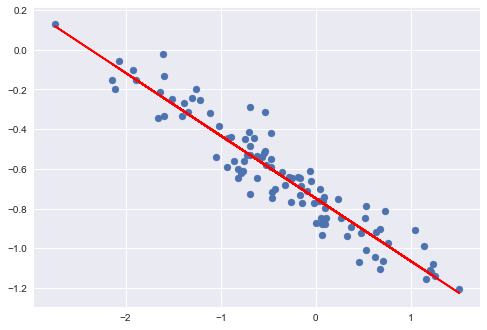

In [8]:
plt.scatter(X[:,0],y)
plt.plot(X[:,0],pred,'r');

In [9]:
mr = make_regression()
X,y = mr.build_dataset(num_important=3, num_rows=100, num_feat=10, bias=True, random_state=42)

In [10]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X,y.reshape(-1,1))
pred = lr.predict(X)

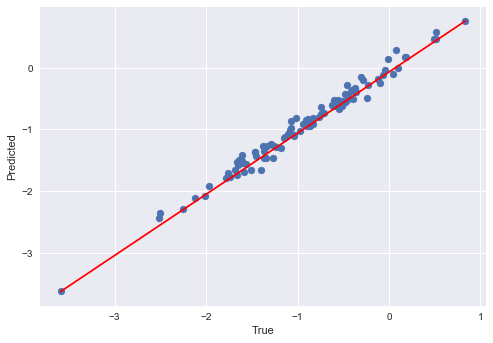

In [11]:
plt.scatter(y, pred)
plt.xlabel("True")
plt.ylabel("Predicted");
plt.plot([min(y),max(y)],[min(pred),max(pred)],'r');

# Now let's add some messiness to the data

In [12]:
mr2 = make_regression()
X,y = mr2.build_dataset(num_feat=8, random_state=42)
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7
0,-0.105473,0.944076,0.483626,0.997896,-1.965025,-0.738749,-0.832927,0.632411
1,-1.401022,2.645584,0.477397,0.986348,0.375630,-0.880723,-1.088476,0.805556
2,-1.287794,0.765223,0.457498,1.463514,-0.411330,-0.810483,-0.439132,0.725450
3,-0.588919,1.114946,0.479612,0.217689,-1.311035,-0.527611,-0.860337,0.934704
4,-0.859748,0.876850,0.448079,0.858750,0.603283,-0.581646,-0.863942,0.753302


In [13]:
pd.DataFrame(mr2.muck_up_data(X, add_nan=False)).head()

,0,1,2,3,4,5,6,7,8,9
0,-0.105473,0.944076,0.483626,0.997896,-1.965025,-0.738749,-0.832927,0.632411,0.632411,1.293801
1,-1.401022,2.645584,0.477397,0.986348,0.375630,-0.880723,-1.088476,0.805556,0.805556,2.613838
2,-1.287794,0.765223,0.457498,1.463514,-0.411330,-0.810483,-0.439132,0.725450,0.725450,1.228757
3,-0.588919,1.114946,0.479612,0.217689,-1.311035,-0.527611,-0.860337,0.934704,0.934704,1.234639
4,-0.859748,0.876850,0.448079,0.858750,0.603283,-0.581646,-0.863942,0.753302,0.753302,1.112784


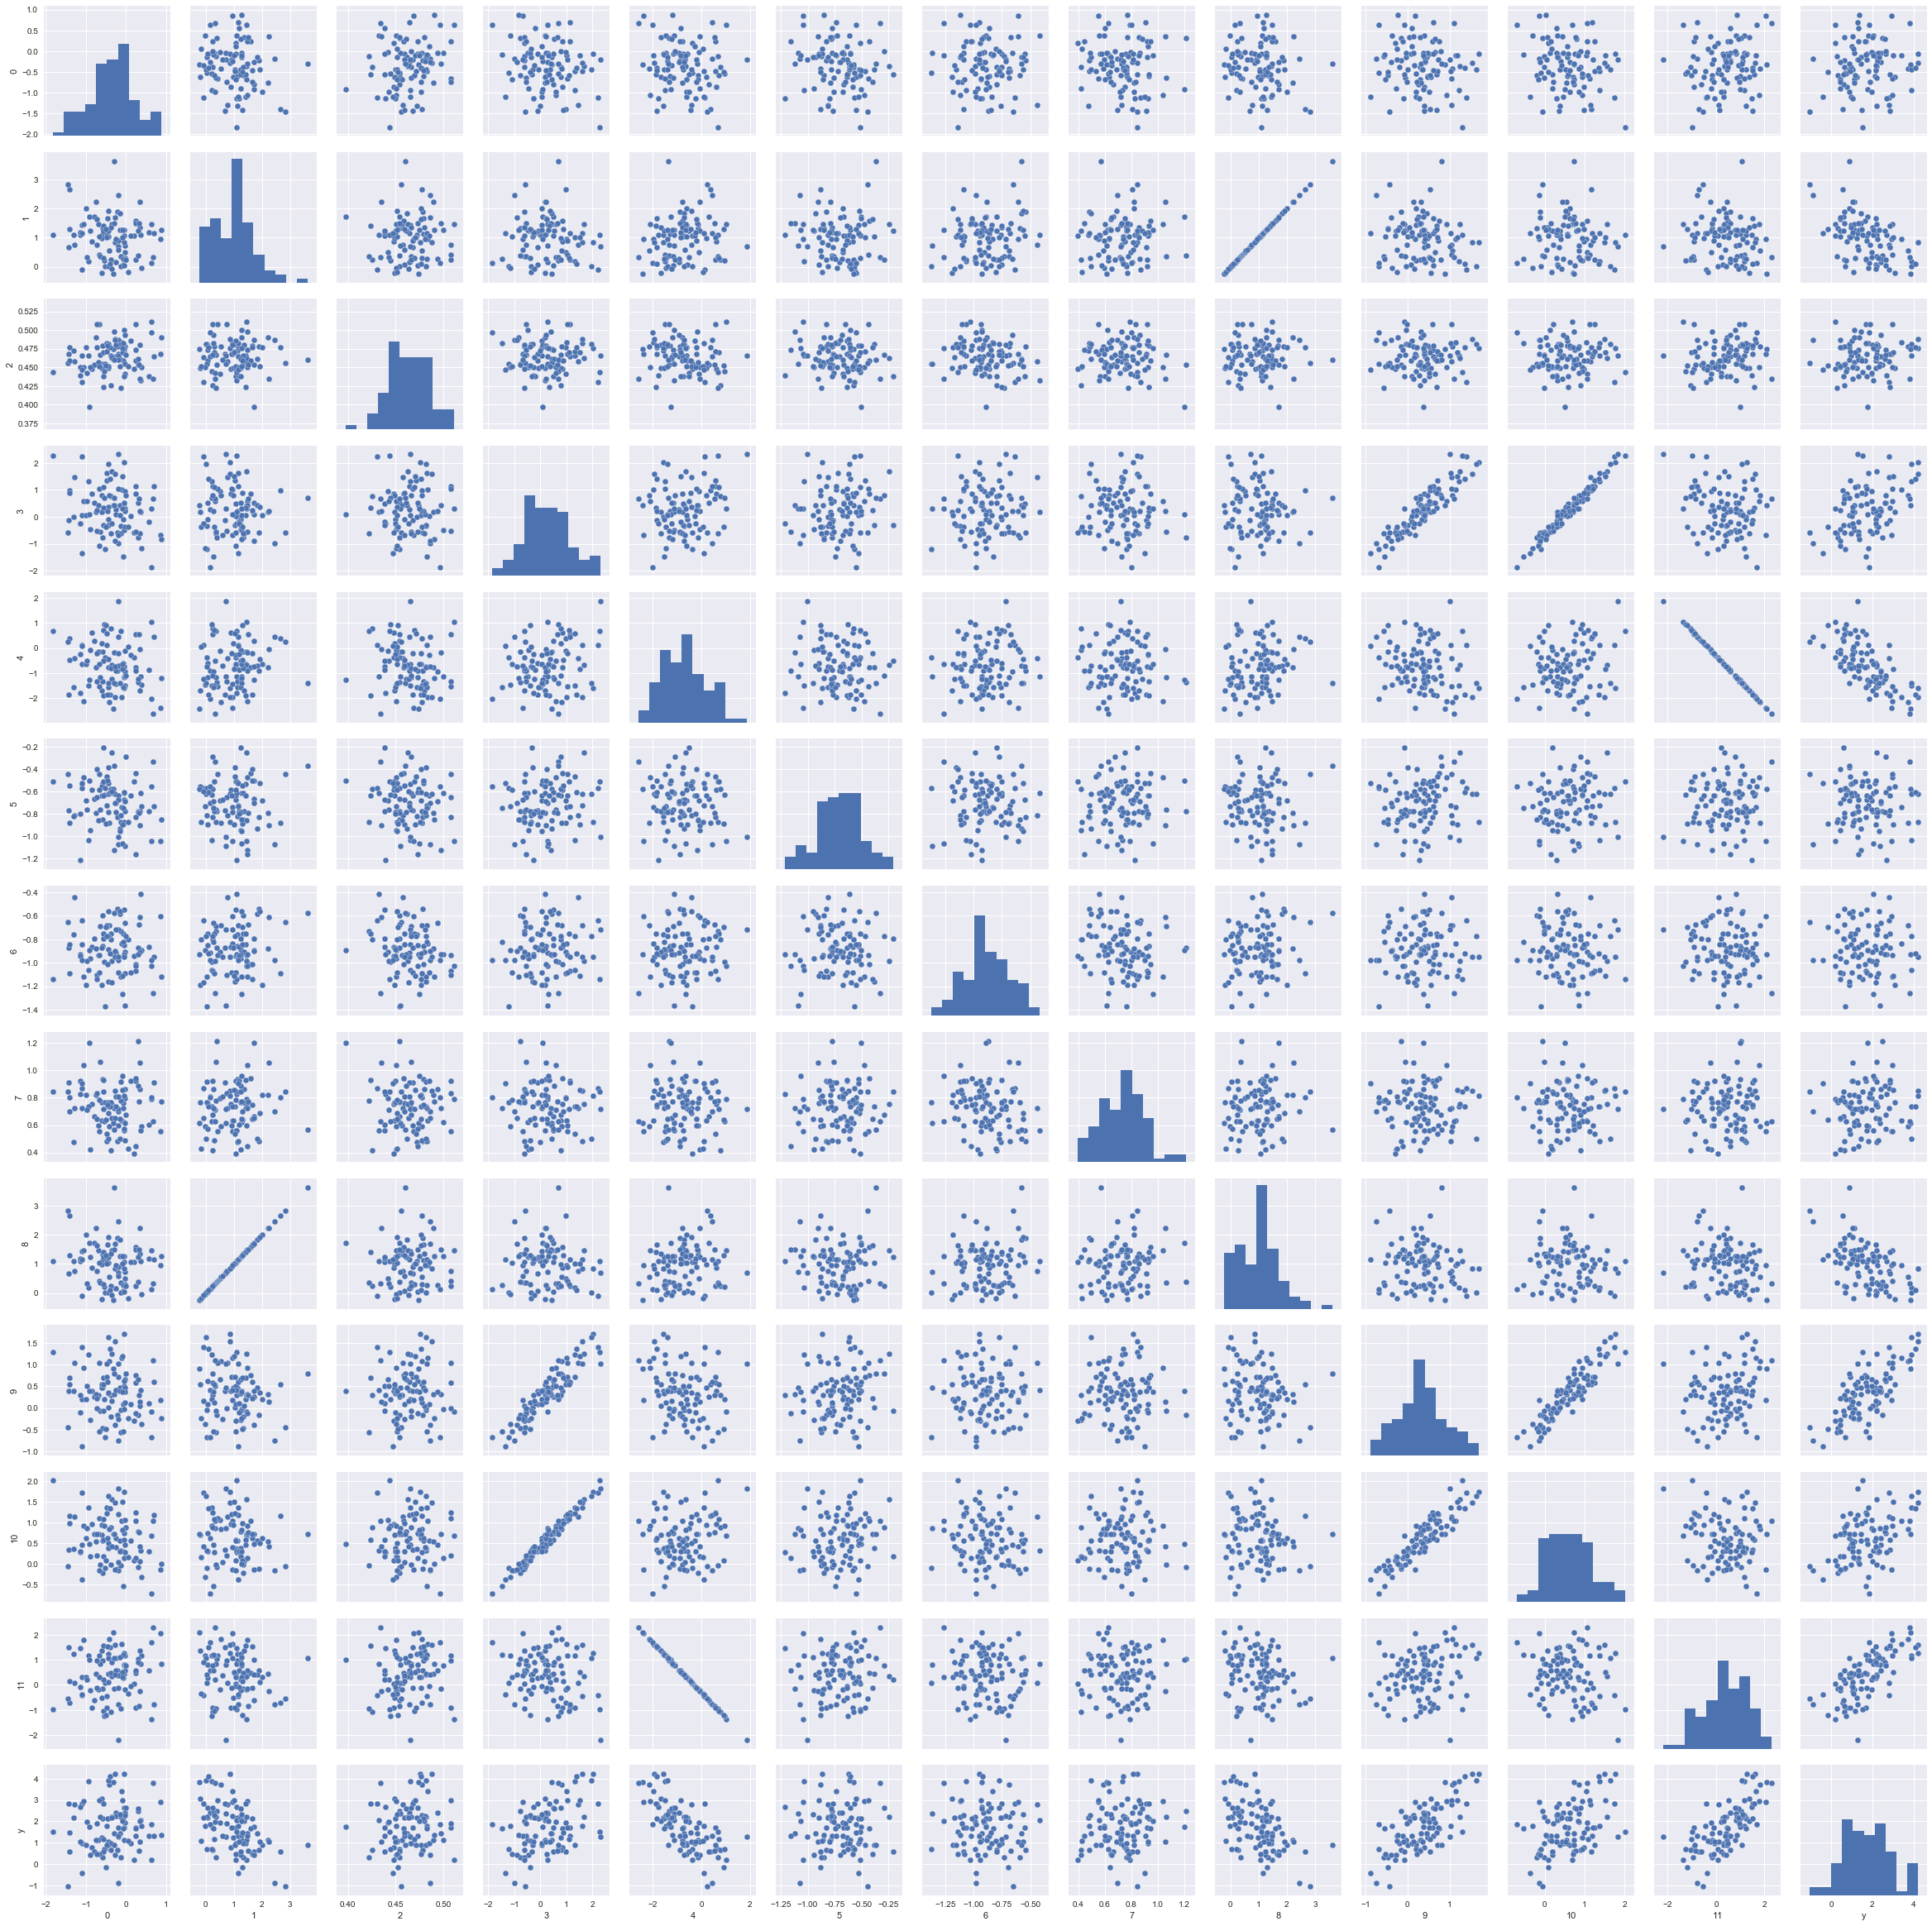

In [14]:
import seaborn as sns
bad_X = pd.DataFrame(mr2.muck_up_data(X, add_nan=False, dup_cols=True, combine_feats=3))
bad_X['y'] = y
sns.pairplot(bad_X);

In [15]:
with_nan = mr2.muck_up_data(X)

In [16]:
pd.DataFrame(mr2.muck_up_data(X, add_nan=0.4)).head()

,0,1,2,3,4,5,6,7,8,9
0,-0.105473,NaN,0.483626,0.997896,NaN,-0.738749,-0.832927,NaN,0.944076,1.154067
1,NaN,2.645584,0.477397,0.986348,0.375630,-0.880723,NaN,NaN,2.645584,1.281811
2,NaN,0.765223,0.457498,NaN,NaN,NaN,-0.439132,0.725450,NaN,1.436676
3,-0.588919,1.114946,0.479612,NaN,-1.311035,NaN,-0.860337,0.934704,1.114946,0.595270
4,NaN,0.876850,NaN,NaN,0.603283,NaN,-0.863942,0.753302,0.876850,0.942439
